# Forecasting with LightGBM

In [50]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgbm
from lightgbm import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('fivethirtyeight')

In [2]:
# load data
filepath = "https://raw.githubusercontent.com/hiydavid/time-series/main/data/PJME_hourly.csv"
pjme = pd.read_csv(filepath, index_col=[0], parse_dates=[0])
pjme.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


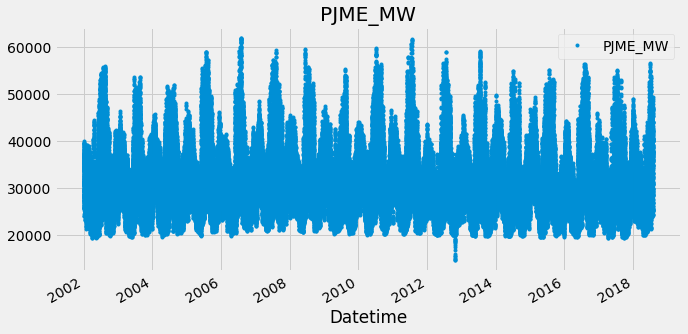

In [13]:
# visualize time series
pjme.plot(style='.', figsize=(10,5), title='PJME_MW')
plt.show()

## Remove Outliers

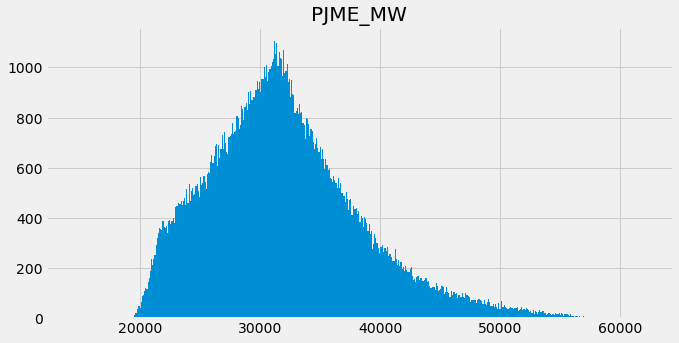

In [9]:
# view value distribution
pjme.hist(bins=500, figsize=(10,5))
plt.show()

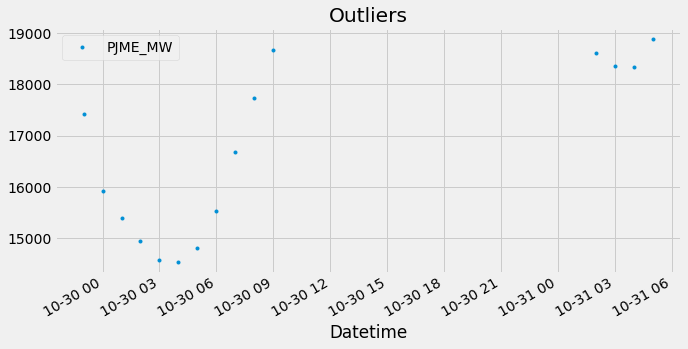

In [22]:
# show value less than 19_000
pjme.query("PJME_MW < 19_000").plot(style=".", figsize=(10,5), title="Outliers")
plt.show()

In [23]:
# filter out outliers
pjme = pjme.query("PJME_MW > 19_000").copy()

## Time Series Cross Validation

In [28]:
# load tss
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
pjme = pjme.sort_index()

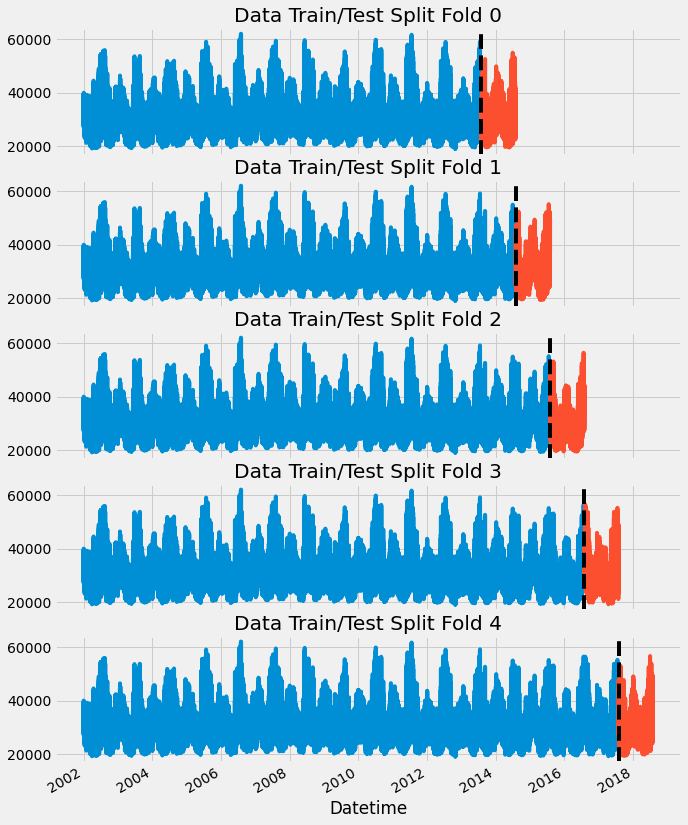

In [30]:
# visualize time series train test split
fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(pjme):
    train = pjme.iloc[train_idx]
    test = pjme.iloc[val_idx]
    train['PJME_MW'].plot(
        ax=axs[fold], 
        label='Training Set', 
        title=f'Data Train/Test Split Fold {fold}'
    )
    test['PJME_MW'].plot(
        ax=axs[fold],
        label='Test Set'
    )
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

## Create Day Features

In [33]:
# function to extract features
def create_datetime_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [34]:
# create datetime features
df = create_datetime_features(pjme)

df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1


## Create Lag Features

In [37]:
# function to create lag features
def create_lag_features(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1yr'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2yr'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3yr'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [38]:
# create lag feature
df = create_lag_features(df)

df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1yr,lag2yr,lag3yr
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


## Train Using Cross Validation

In [39]:
# split
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [51]:
# train
fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    
    features = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1yr', 'lag2yr', 'lag3yr']
    target = "PJME_MW"

    xtrain, ytrain = train[features], train[target]
    xval, yval = val[features], val[target]

    reg = lgbm.LGBMRegressor(n_estimators=1000)
    reg.fit(
        xtrain, 
        ytrain,
        eval_set=[(xtrain, ytrain), (xval, yval)],
        early_stopping_rounds=50
    )

    ypred = reg.predict(xval)
    preds.append(ypred)

    score = mean_absolute_percentage_error(yval, ypred)
    scores.append(score)


[1]	training's l2: 3.67624e+07	valid_1's l2: 3.32941e+07
Training until validation scores don't improve for 50 rounds
[2]	training's l2: 3.23207e+07	valid_1's l2: 2.92858e+07
[3]	training's l2: 2.86113e+07	valid_1's l2: 2.60464e+07
[4]	training's l2: 2.55663e+07	valid_1's l2: 2.34426e+07
[5]	training's l2: 2.30927e+07	valid_1's l2: 2.13794e+07
[6]	training's l2: 2.10217e+07	valid_1's l2: 1.96778e+07
[7]	training's l2: 1.9289e+07	valid_1's l2: 1.83686e+07
[8]	training's l2: 1.78764e+07	valid_1's l2: 1.73359e+07
[9]	training's l2: 1.67019e+07	valid_1's l2: 1.65799e+07
[10]	training's l2: 1.56706e+07	valid_1's l2: 1.59316e+07
[11]	training's l2: 1.48516e+07	valid_1's l2: 1.54085e+07
[12]	training's l2: 1.41018e+07	valid_1's l2: 1.49679e+07
[13]	training's l2: 1.34692e+07	valid_1's l2: 1.4731e+07
[14]	training's l2: 1.28991e+07	valid_1's l2: 1.43623e+07
[15]	training's l2: 1.24153e+07	valid_1's l2: 1.42536e+07
[16]	training's l2: 1.20462e+07	valid_1's l2: 1.41313e+07
[17]	training's l2: 1.

In [52]:
# check training scores
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0868
Fold scores:[0.081612044635865, 0.07449641483491795, 0.0984831691054158, 0.08989190070641496, 0.08936402166921859]


## Predictions

In [61]:
# train on all samples
xall = df[features]
yall = df[target]

reg = lgbm.LGBMRegressor(n_estimators=1000)
reg.fit(
    xtrain, 
    ytrain,
    eval_set=[(xall, yall)],
    early_stopping_rounds=50
)

[1]	valid_0's l2: 3.64655e+07
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 3.21305e+07
[3]	valid_0's l2: 2.85608e+07
[4]	valid_0's l2: 2.56462e+07
[5]	valid_0's l2: 2.32785e+07
[6]	valid_0's l2: 2.12916e+07
[7]	valid_0's l2: 1.96705e+07
[8]	valid_0's l2: 1.83056e+07
[9]	valid_0's l2: 1.71775e+07
[10]	valid_0's l2: 1.62324e+07
[11]	valid_0's l2: 1.54382e+07
[12]	valid_0's l2: 1.47116e+07
[13]	valid_0's l2: 1.41282e+07
[14]	valid_0's l2: 1.36394e+07
[15]	valid_0's l2: 1.32399e+07
[16]	valid_0's l2: 1.2869e+07
[17]	valid_0's l2: 1.25317e+07
[18]	valid_0's l2: 1.22736e+07
[19]	valid_0's l2: 1.20244e+07
[20]	valid_0's l2: 1.18075e+07
[21]	valid_0's l2: 1.15916e+07
[22]	valid_0's l2: 1.13596e+07
[23]	valid_0's l2: 1.12049e+07
[24]	valid_0's l2: 1.10525e+07
[25]	valid_0's l2: 1.09388e+07
[26]	valid_0's l2: 1.07921e+07
[27]	valid_0's l2: 1.06779e+07
[28]	valid_0's l2: 1.05538e+07
[29]	valid_0's l2: 1.0413e+07
[30]	valid_0's l2: 1.02822e+07
[31]	valid_0's l2: 1

LGBMRegressor(n_estimators=1000)

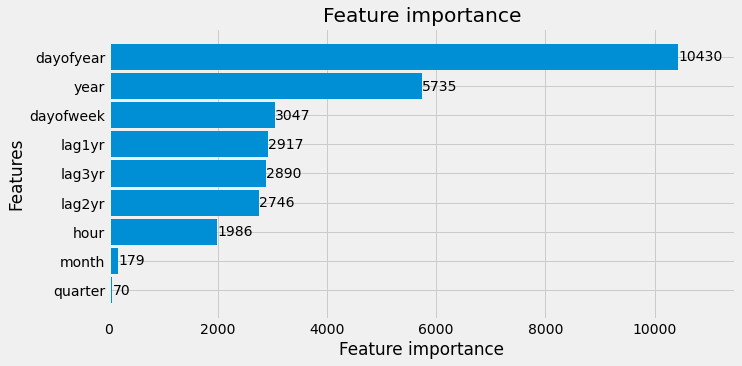

In [62]:
# feature importance scores
plot_importance(reg, height=0.9, figsize=(10,5))
plt.show()

In [71]:
# create future dataframe
from_date = df.index.max() + pd.Timedelta("1 day")
to_date = df.index.max() + pd.Timedelta("365 day")

future = pd.date_range(from_date, to_date, freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_datetime_features(df_and_future)
df_and_future = create_lag_features(df_and_future)

df_and_future.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1yr,lag2yr,lag3yr,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False


In [72]:
# future dataframe only
future_w_features = df_and_future.query("isFuture").copy()

future_w_features.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1yr,lag2yr,lag3yr,isFuture
2018-08-04 00:00:00,NaN,0,5,3,8,2018,216,4,31,34310.0,33373.0,30618.0,True
2018-08-04 01:00:00,NaN,1,5,3,8,2018,216,4,31,31720.0,31016.0,28106.0,True
2018-08-04 02:00:00,NaN,2,5,3,8,2018,216,4,31,29985.0,29342.0,26342.0,True
2018-08-04 03:00:00,NaN,3,5,3,8,2018,216,4,31,28747.0,28254.0,25138.0,True
2018-08-04 04:00:00,NaN,4,5,3,8,2018,216,4,31,27764.0,27658.0,24356.0,True


In [73]:
# make prediction
future_w_features["pred"] = reg.predict(future_w_features[features])

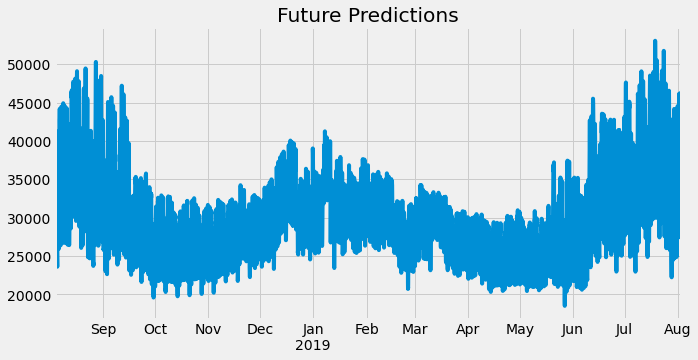

In [74]:
# plot prediction
future_w_features['pred'].plot(
    figsize=(10, 5),
    title='Future Predictions'
)
plt.show()